In [51]:
## Import all the necessary libraries

import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pathlib
from tensorflow.keras.layers import Layer, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [12]:
## Link to public datasets of flower images. It will download the dataset and store it in the Keras API dataset storage
dataset_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

path_Dir = tf.keras.utils.get_file('flower_photos', origin=dataset_URL, untar=True)

path_Dir = pathlib.Path(path_Dir)
print(f"Path to directory of the datasets: {path_Dir}")

Path to directory of the datasets: C:\Users\WINDOWS\.keras\datasets\flower_photos


In [34]:
## Define the width and height of the image
width, height = 180, 180

batch_size = 32 ## It could be any size, adjust this to your system RAM availability
val_split = 0.2 ## Validation data split. Ranging from 0 to 1

## Initiate a keras dataset object generator for train and validation dataset respectively
train_set = tf.keras.utils.image_dataset_from_directory(
    path_Dir,
    validation_split=val_split,
    subset="training",
    image_size=(height, width),
    batch_size=batch_size,
    seed=42
)

val_set = tf.keras.utils.image_dataset_from_directory(
    path_Dir,
    validation_split=val_split,
    subset="validation",
    image_size=(height, width),
    batch_size=batch_size,
    seed=42
)

class_names = train_set.class_names
print(f"Class name of the dataset = {class_names}")

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
Class name of the dataset = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


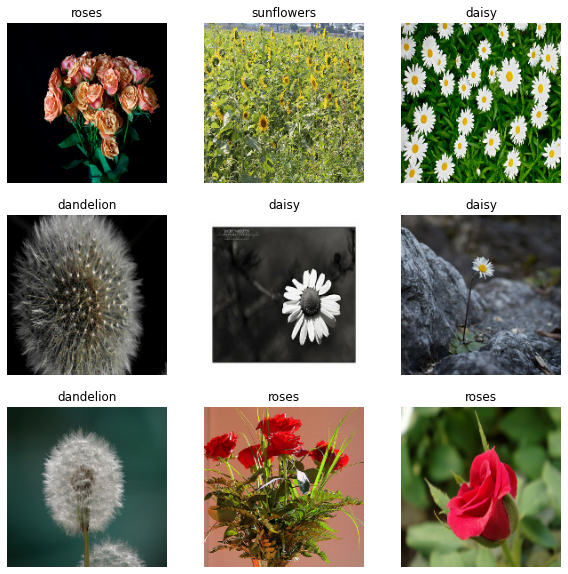

In [48]:
## Visualize 9 random images from the dataset
plt.figure(figsize=(10, 10))
plt_seed = np.random.randint(batch_size-9)
batch_seed = np.random.randint(10)

for images, labels in train_set.take(batch_seed):
    for i in range(plt_seed, plt_seed+9):
        ax = plt.subplot(3, 3, i-plt_seed+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [50]:
## Loads up the ResNet50 model from the Keras API
resnet_model = Sequential()

pretrained = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(height, width, 3),
    pooling='avg',
    classes=5,
    weights='imagenet'
)

## Freeze up all the layer in the ResNet50 so the weight can't be trained again
for layer in pretrained.layers:
    layer.trainable = False
    
## Add the freezed ResNet50 weight into our own model
resnet_model.add(pretrained)
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
## Adjusting our custom model on top of the pretrained layer from ResNet50
resnet_model.add(Flatten())
resnet_model.add(BatchNormalization())
resnet_model.add(Dense(512, activation="relu"))
resnet_model.add(Dropout(0.5))
resnet_model.add(BatchNormalization())
resnet_model.add(Dense(128, activation="relu"))
resnet_model.add(Dropout(0.5))
resnet_model.add(BatchNormalization())

## Final layer is the output dense layer which correspond to the number of class in the dataset
num_class = 